In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import SpectralToolbox.Spectral1D as S1D
import TransportMaps as TM
import TransportMaps.Maps as MAPS
import TransportMaps.Distributions as DIST
%matplotlib inline

# Composition of maps
Let us now consider the random variable $x \sim Be(\alpha,\beta) = \nu_\pi$. The associated PDF is given by

$$
\pi(x) =  \frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)} \;.
$$

We select the standard normal reference density $\nu_\rho$. Notice that the **supports** of $\nu_\rho$ and $\nu_\pi$ are different.

This means that a map $M$ s.t. $M_\sharp \nu_\rho \approx \nu_\pi$ will have to concetrate all the mass of $\nu_\rho$ on the support of $\nu_\pi$. Consequentely, we want $M:\mathbb{R} \rightarrow [0,1]$. 

If the problem was to be formulated as usual, we would have to solve:

$$
\hat{M} = \arg \min_{M \in \mathcal{T}_\triangle} \mathcal{D}_{\rm KL}\left( M_\sharp \nu_\rho \Vert \nu_\pi \right) = \arg \min_{M \in \mathcal{T}_\triangle} \mathbb{E}_{\rho}\left[ -\log \pi \circ M - \log \left\vert \nabla_{\bf x} M \right\vert \right] \;.
$$

A direct solution of such problem, without imposing conditons on $\mathcal{T}_\triangle$, can lead to the evaluation of $\pi$ outside its support.

To circumvent this problem we will look for the approximation $T^\star_\sharp \nu_\rho \approx L^\sharp \nu_\pi$, where $L:\mathbb{R}\rightarrow[0,1]$. A common choice for this map is the CDF of the $\mathcal{U}([0,1])$ distribution. We will then solve the problem:

$$
\hat{T} = \arg \min_{T \in \mathcal{T}_\triangle} \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \Vert L^\sharp \nu_\pi \right)\;.
$$

The approximation of the target distribution will then be given by the **composition**: 

$$(L \circ \hat{T})_\sharp \nu_\rho = L_{\sharp} \hat{T}_{\sharp} \nu_\rho = \nu_\pi \;.$$

Let's define the target Beta distribution ...

In [2]:
class BetaDistribution(DIST.Distribution):
    def __init__(self, alpha, beta):
        super(BetaDistribution,self).__init__(1)
        self.alpha = alpha
        self.beta = beta
        self.dist = stats.beta(alpha, beta)
    def pdf(self, x, params=None):
        return self.dist.pdf(x).flatten()
    def log_pdf(self, x, params=None):
        return self.dist.logpdf(x).flatten()
    def grad_x_log_pdf(self, x, params=None):
        a = self.alpha
        b = self.beta
        out = ((a-1.)/x + (b-1.)/(x-1.))
        return out
    def hess_x_log_pdf(self, x, params=None):
        a = self.alpha
        b = self.beta
        out = (1.-a)/x**2. + (1-b)/(x-1.)**2.
        return out[:,:,np.newaxis]
alpha = 2.
beta = 5.
pi = BetaDistribution(alpha, beta)

... let's check how its PDF looks like...

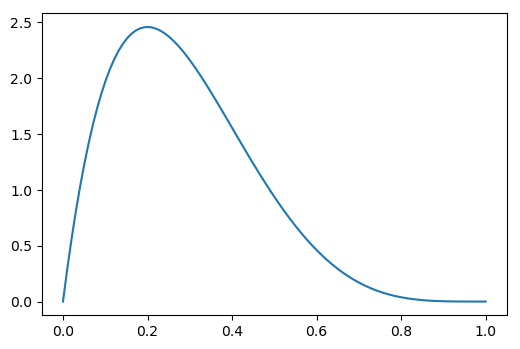

In [3]:
x = np.linspace(1e-10, 1.-1e-10, 100).reshape((100,1))
plt.figure()
plt.plot(x, pi.pdf(x));

...for the sake of exposition, let us define the exact transport map $L \circ T^\star$...

In [4]:
# Support map L
L = MAPS.FrozenGaussianToUniformDiagonalTransportMap(1)
# Exact map T^*
class BetaTransportMap(object):
    def __init__(self, alpha, beta):
        self.tar = stats.beta(alpha, beta)
        self.ref = stats.norm(0.,1.)
    def invsuppmap(self, x, params=None):
        if isinstance(x,float):
            x = np.array([[x]])
        if x.ndim == 1:
            x = x[:,NAX]
        std = stats.norm()
        spd = stats.uniform()
        out = std.ppf( spd.cdf( x ) )
        return out
    def evaluate(self, x, params=None):
        if isinstance(x,float):
            x = np.array([[x]])
        if x.ndim == 1:
            x = x[:,NAX]
        out = self.invsuppmap( self.tar.ppf( self.ref.cdf(x) ) )
        return out
    def __call__(self, x):
        return self.evaluate(x)
Tstar = BetaTransportMap(alpha, beta)

...let's see how the exact transport map $L\circ T^\star$ looks like...

In [5]:
x_tm = np.linspace(-6,6,100).reshape((100,1))
def plot_mapping(L, tar_star, Tstar, tar=None, T=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_twx = ax.twinx()
    ax_twy = ax.twiny()
    ax.plot(x_tm, L(Tstar(x_tm)), 'k-', label=r"$T^\star$") # Map
    n01, = ax_twx.plot(x_tm, stats.norm(0.,1.).pdf(x_tm), '-b') # N(0,1)
    g, = ax_twy.plot(tar_star.pdf(L(Tstar(x_tm))), L(Tstar(x_tm)), '-r') # Gumbel
    if T is not None:
        ax.plot(x_tm, L(T(x_tm)), 'k--', label=r"$\hat{T}$") # Map
    if tar is not None:
        ax_twy.plot(tar.pdf(L(Tstar(x_tm))), L(Tstar(x_tm)), '--r') # Gumbel
    ax.set_ylabel(r"Map")
    ax_twx.set_ylabel('N(0,1)')
    ax_twx.yaxis.label.set_color(n01.get_color())
    ax_twy.set_xlabel('Gumbel')
    ax_twy.xaxis.label.set_color(g.get_color())
    ax.legend(loc = (0.1, 0.8))

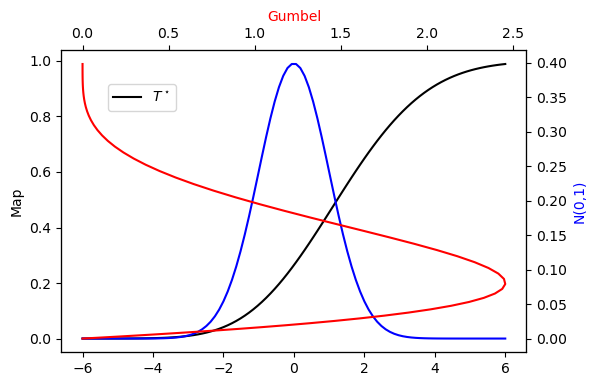

In [6]:
plot_mapping(L, pi, Tstar)

## Integrated squared parametrization
Along the lines of the [previous](example-gumbel-1d.html) example, we construct an [integrated squared parametrization](example-gumbel-1d.html#Integrated-squared-parametrization) of 3-rd order ...

In [7]:
order = 3
T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    1, order, 'full')

... define the reference density $\nu_\rho$ and transport map density $T_\sharp \nu_\rho$ ...

In [8]:
rho = DIST.StandardNormalDistribution(1)
push_T_rho = DIST.PushForwardTransportMapDistribution(T, rho)

... and in this case the support mapping density $L^\sharp \nu_\pi$ ...

In [9]:
pull_L_pi = DIST.PullBackTransportMapDistribution(L,pi)

... finally we are ready to solve the KL-divergence minimization problem ...

In [10]:
qtype = 3      # Gauss quadrature
qparams = [20] # Quadrature order
reg = None     # No regularization
tol = 1e-10    # Optimization tolerance
ders = 2       # Use gradient and Hessian 
log = push_T_rho.minimize_kl_divergence(
    pull_L_pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

Now we need to construct the density $L_\sharp T_\sharp \nu_\rho \approx \nu_\pi$ by composition of the maps $L$ and $T$

In [11]:
push_LT_rho = DIST.PushForwardTransportMapDistribution(L, push_T_rho)

Alternatively we can construct $(L\circ T)_\sharp \nu_\rho \approx \nu_\pi$

In [12]:
LT = MAPS.CompositeTransportMap(L, T)
push_LT_rho = DIST.PushForwardTransportMapDistribution(LT, rho)

... and we can now look at the approximated PDF and transport map ...

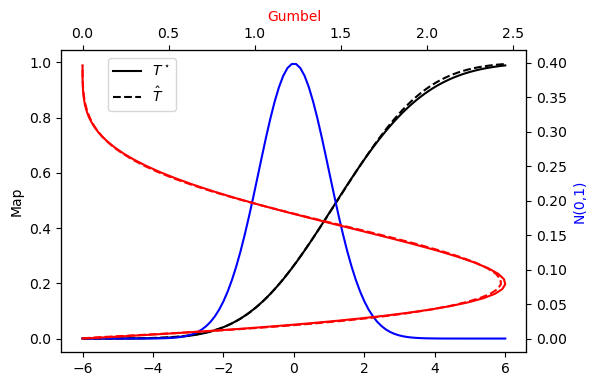

In [13]:
plot_mapping(L, pi, Tstar, push_LT_rho, T)

## Sampling from the approximation


### Monte-Carlo sampling


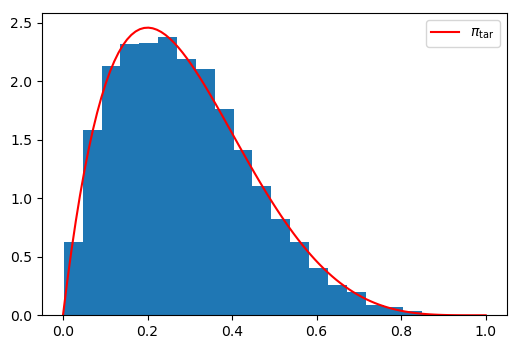

In [14]:
M = 10000
samples = push_LT_rho.rvs(M)
plt.figure()
plt.hist(samples,bins=20,normed=True);
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.legend();

### Gauss quadratures


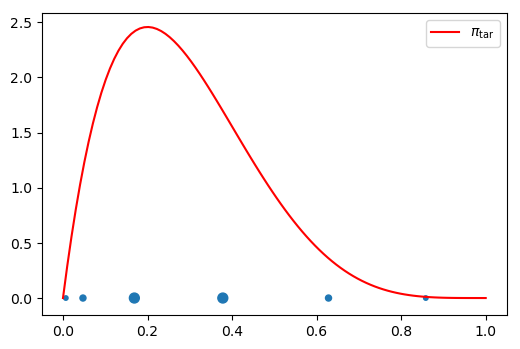

In [15]:
M = 5
(xq,wq) = push_LT_rho.quadrature(qtype=3, qparams=[M])
plt.figure()
plt.plot(x, pi.pdf(x),'r',label=r'$\pi_{\rm tar}$');
plt.scatter(xq, np.zeros(len(xq)), s=100*wq+10);
plt.legend();